# Ungraded Lab: Cats vs. Dogs Class Activation Maps

You will again practice with CAMs in this lab and this time there will only be two classes: Cats and Dogs. You will be revisiting this exercise in this week's programming assignment so it's best if you become familiar with the steps discussed here, particularly in preprocessing the image and building the model.

In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 17s (25.1 MB/s)
(Reading database ... 124016 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 123993 files and directories currently installed.)
Prepar

## Imports

In [2]:
# NOTE (05/11/2022) - The default URL for downloading the dataset via TFDS is currently invalid. This piece of code
# will patch that URL with the correct one. Please run this before importing the packages. If it fails, kindly report
# in our Discourse community. Thank you!

DATASET_PATH = '/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py'
!sed -i 's/3367a/5340/g' {DATASET_PATH}

sed: can't read /usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py: No such file or directory


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

In [5]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteE3DXZT/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The cell below will preprocess the images and create batches before feeding it to our model.

In [6]:
def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

## Build the classifier

This will look familiar to you because it is almost identical to the previous model we built. The key difference is the output is just one unit that is sigmoid activated. This is because we're only dealing with two classes.

In [7]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0

The loss can be adjusted from last time to deal with just two classes. For that, we pick `binary_crossentropy`.

In [8]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
model.fit(train_batches,epochs=25)

Epoch 1/25


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


582/582 [==============================] - 73s 113ms/step - loss: 0.6592 - accuracy: 0.5977
Epoch 2/25
582/582 [==============================] - 68s 114ms/step - loss: 0.6238 - accuracy: 0.6480
Epoch 3/25
582/582 [==============================] - 67s 112ms/step - loss: 0.6028 - accuracy: 0.6765
Epoch 4/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5834 - accuracy: 0.6962
Epoch 5/25
582/582 [==============================] - 67s 112ms/step - loss: 0.5684 - accuracy: 0.7091
Epoch 6/25
582/582 [==============================] - 67s 112ms/step - loss: 0.5587 - accuracy: 0.7196
Epoch 7/25
582/582 [==============================] - 68s 114ms/step - loss: 0.5455 - accuracy: 0.7296
Epoch 8/25
582/582 [==============================] - 67s 112ms/step - loss: 0.5353 - accuracy: 0.7370
Epoch 9/25
582/582 [==============================] - 68s 115ms/step - loss: 0.5257 - accuracy: 0.7504
Epoch 10/25
582/582 [==============================] - 67s 112ms/step - loss: 0.5168

## Building the CAM model

You will follow the same steps as before in generating the class activation maps.

In [9]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496 

In [10]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


## Testing the Model

Let's download a few images and see how the class activation maps look like.

In [11]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

--2022-12-24 04:02:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.003s  

2022-12-24 04:02:14 (155 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2022-12-24 04:02:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg

1/1 [==============================] - 0s 245ms/step
sigmoid output: [[0.00281687]]
prediction: cat


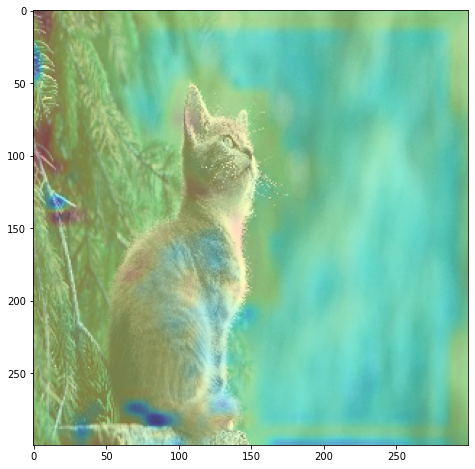

1/1 [==============================] - 0s 17ms/step
sigmoid output: [[0.39447203]]
prediction: cat


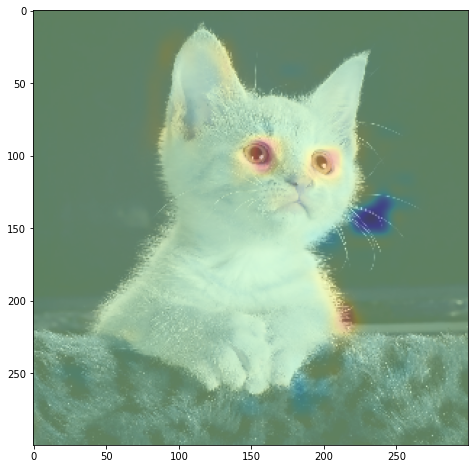

1/1 [==============================] - 0s 27ms/step
sigmoid output: [[0.54452974]]
prediction: dog


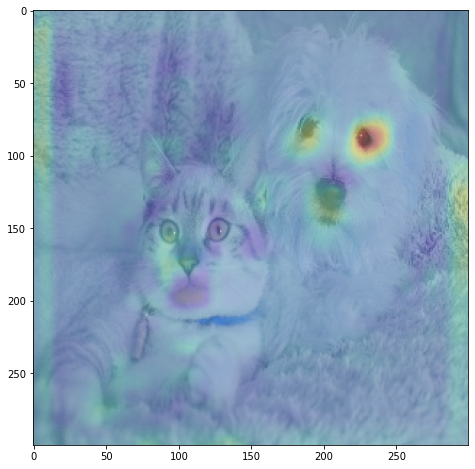

1/1 [==============================] - 0s 15ms/step
sigmoid output: [[0.16436547]]
prediction: cat


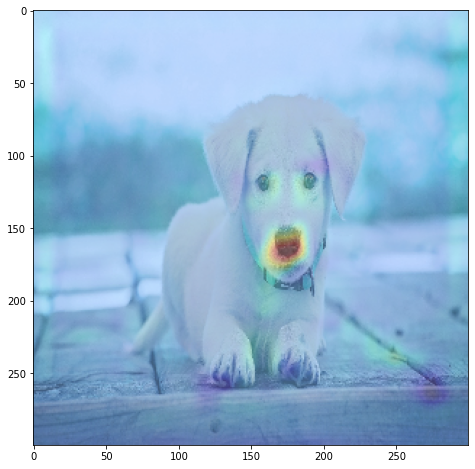

1/1 [==============================] - 0s 22ms/step
sigmoid output: [[0.29977247]]
prediction: cat


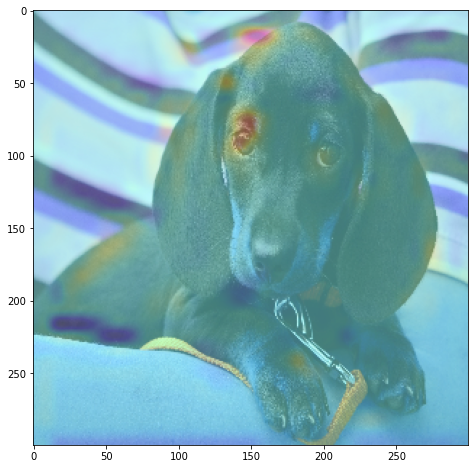

In [12]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

Let's also try it with some of the test images before we make some observations.

ground truth: cat
1/1 [==============================] - 0s 17ms/step
sigmoid output: [[0.404739]]
prediction: cat


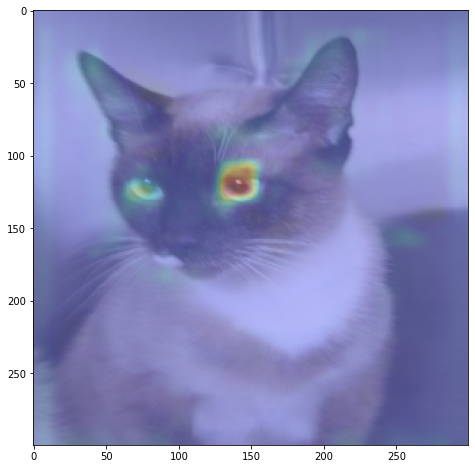

ground truth: dog
1/1 [==============================] - 0s 17ms/step
sigmoid output: [[0.34336367]]
prediction: cat


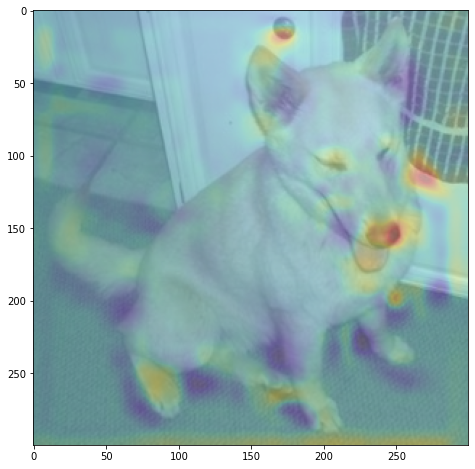

ground truth: dog
1/1 [==============================] - 0s 19ms/step
sigmoid output: [[0.46413368]]
prediction: cat


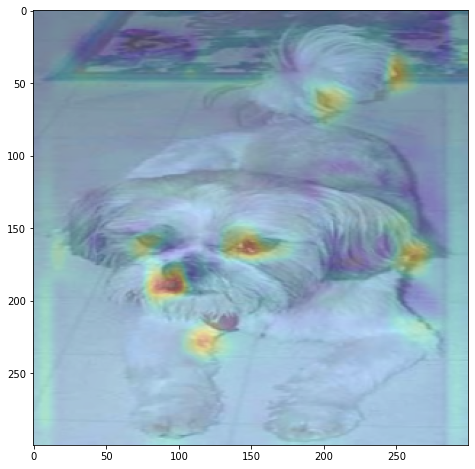

ground truth: cat
1/1 [==============================] - 0s 21ms/step
sigmoid output: [[0.00586785]]
prediction: cat


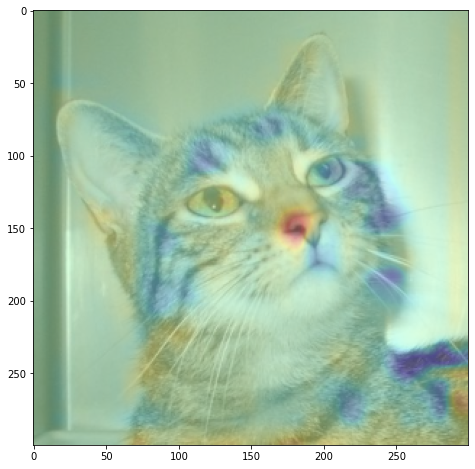

ground truth: cat
1/1 [==============================] - 0s 27ms/step
sigmoid output: [[0.28301936]]
prediction: cat


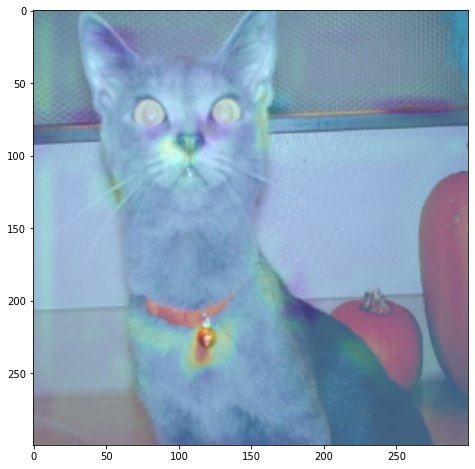

In [13]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)

If your training reached 80% accuracy, you may notice from the images above that the presence of eyes and nose play a big part in determining a dog, while whiskers and a colar mostly point to a cat. Some can be misclassified based on the presence or absence of these features. This tells us that the model is not yet performing optimally and we need to tweak our process (e.g. add more data, train longer, use a different model, etc).